## Importación de librerías

In [1]:
# Librerías para cálculos y visualización
# SEMILLA REPRODUCIBLE
import numpy as np
np.random.seed(42)

# Librerías para cálculos y visualización
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Importar tu motor de red neuronal
from src.network import NeuralNetwork
from src.dense import Dense
from src.activations import ReLU, Softmax
from src.losses import CrossEntropyLoss
from src.optimizer import Adam
from src.trainer import Trainer



Importamos librerías necesarias y tu implementación propia de la red.

## Cargar y preparar MNIST 

In [2]:
# Descargar MNIST desde OpenML
mnist = fetch_openml('mnist_784', version=1, cache=True)
X, y = mnist["data"], mnist["target"].astype(np.int64)

# Convertir a NumPy (MUY IMPORTANTE)
X = X.to_numpy()
y = y.to_numpy()

# Normalizar imágenes a [0,1]
X = X / 255.0

# Dividir en train (60%), val (20%), test (20%)
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print("Shapes:")
print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)


Shapes:
Train: (42000, 784)
Val:   (14000, 784)
Test:  (14000, 784)


Se cargan y normalizan las imágenes.

## Codificar etiquetas a one-hot


In [3]:
encoder = OneHotEncoder(sparse_output=False)

y_train_oh = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_oh   = encoder.transform(y_val.reshape(-1, 1))
y_test_oh  = encoder.transform(y_test.reshape(-1, 1))

print("Shapes OHE:", y_train_oh.shape, y_val_oh.shape, y_test_oh.shape)


Shapes OHE: (42000, 10) (14000, 10) (14000, 10)


Tu Trainer requiere que las etiquetas sean one-hot.

## Crear la red neuronal y el trainer


In [5]:
network = NeuralNetwork([
    Dense(784, 128, initialization="he"),
    ReLU(),
    Dense(128, 10, initialization="xavier"),
    Softmax()
])

loss_fn = CrossEntropyLoss()

# Adam con L2 (weight_decay=1e-4)  ← NUEVO
optimizer = Adam(lr=0.001, weight_decay=1e-4)

# Trainer con early stopping (patience=6)  ← NUEVO
trainer = Trainer(network, optimizer, loss_fn, patience=6, verbose=True)

print("Red inicializada correctamente.")


Red inicializada correctamente.


Se define la arquitectura y se crea el entrenador.

## Entrenamiento durante 30 épocas


In [6]:
history = trainer.train(
    X_train, y_train_oh,
    X_val,   y_val_oh,
    epochs=30,
    batch_size=64
)


Epoch 1/30 - TrainLoss=0.3437 - ValLoss=0.1968 - ValAcc=0.9449
Epoch 2/30 - TrainLoss=0.1602 - ValLoss=0.1456 - ValAcc=0.9584
Epoch 3/30 - TrainLoss=0.1147 - ValLoss=0.1264 - ValAcc=0.9623
Epoch 4/30 - TrainLoss=0.0891 - ValLoss=0.1051 - ValAcc=0.9688
Epoch 5/30 - TrainLoss=0.0733 - ValLoss=0.1047 - ValAcc=0.9713
Epoch 6/30 - TrainLoss=0.0602 - ValLoss=0.0960 - ValAcc=0.9708
Epoch 7/30 - TrainLoss=0.0513 - ValLoss=0.0907 - ValAcc=0.9719
Epoch 8/30 - TrainLoss=0.0444 - ValLoss=0.0896 - ValAcc=0.9739
Epoch 9/30 - TrainLoss=0.0390 - ValLoss=0.0917 - ValAcc=0.9726
Epoch 10/30 - TrainLoss=0.0329 - ValLoss=0.0881 - ValAcc=0.9740
Epoch 11/30 - TrainLoss=0.0306 - ValLoss=0.0842 - ValAcc=0.9751
Epoch 12/30 - TrainLoss=0.0262 - ValLoss=0.0864 - ValAcc=0.9750
Epoch 13/30 - TrainLoss=0.0246 - ValLoss=0.0792 - ValAcc=0.9765
Epoch 14/30 - TrainLoss=0.0227 - ValLoss=0.0848 - ValAcc=0.9757
Epoch 15/30 - TrainLoss=0.0203 - ValLoss=0.0807 - ValAcc=0.9750
Epoch 16/30 - TrainLoss=0.0202 - ValLoss=0.0849 -

Entrenamos 30 épocas con batch size 64.
El history guarda pérdida y precisión para gráficas.

## Graficar pérdida y precisión


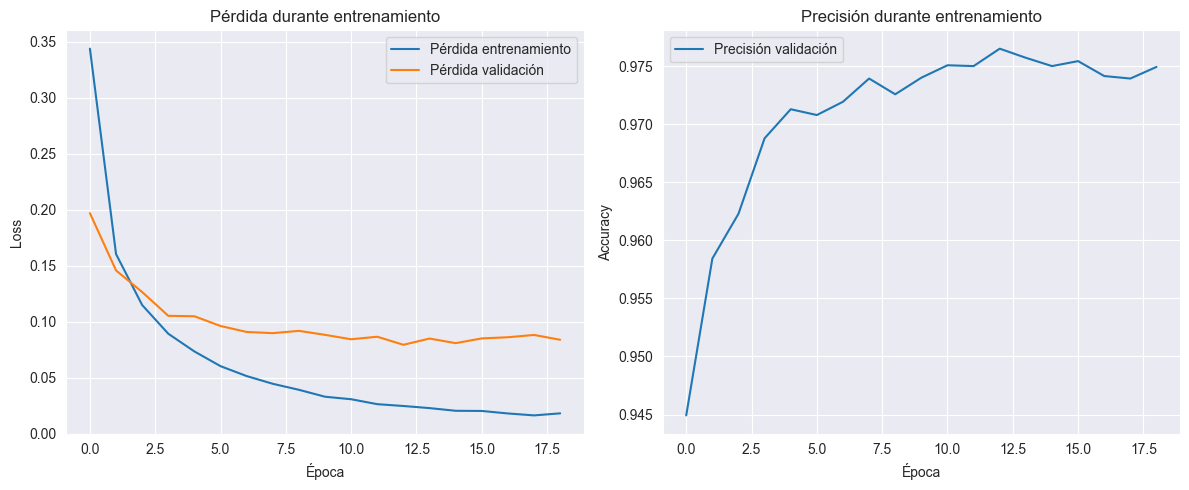

In [7]:
# Graficar pérdida y precisión
plt.figure(figsize=(12,5))

# Pérdida
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Pérdida entrenamiento")
plt.plot(history["val_loss"], label="Pérdida validación")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Pérdida durante entrenamiento")
plt.legend()

# Precisión
plt.subplot(1,2,2)
plt.plot(history["val_acc"], label="Precisión validación")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Precisión durante entrenamiento")
plt.legend()

plt.tight_layout()
plt.show()


Se visualizan las métricas de entrenamiento por época.

## Evaluación final en test set


In [8]:
test_pred = network.forward(X_test)
test_loss = loss_fn.forward(test_pred, y_test_oh)
test_acc = np.mean(np.argmax(test_pred, axis=1) == np.argmax(y_test_oh, axis=1))

print(f"Pérdida en test: {test_loss:.4f}, Precisión en test: {test_acc:.4f}")


Pérdida en test: 0.0773, Precisión en test: 0.9759


Obtenemos métricas finales para la memoria.

## Guardar gráfica para la memoria


Gráfica guardada como 'resultados_entrenamiento.png'.


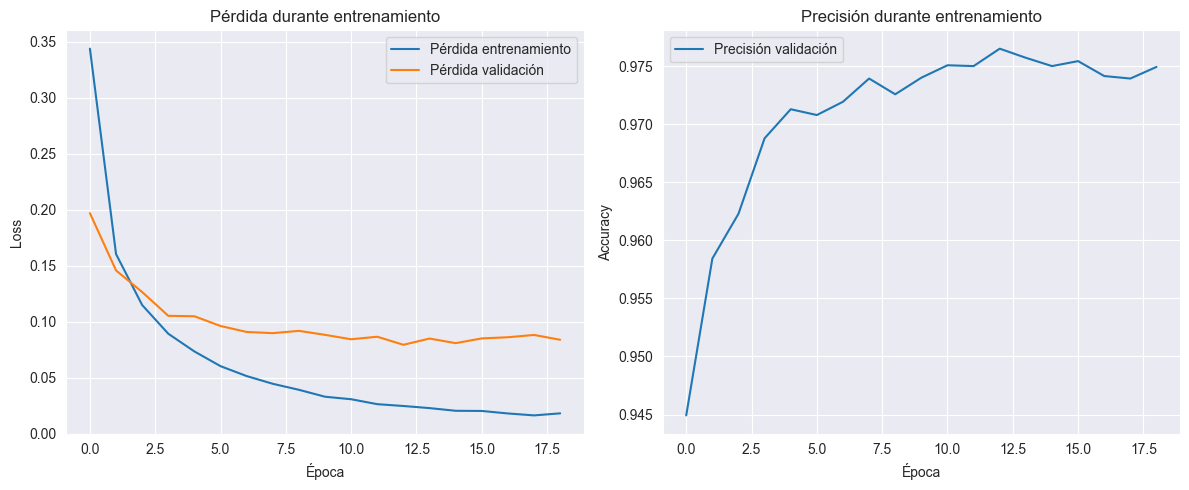

In [9]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Pérdida entrenamiento")
plt.plot(history["val_loss"], label="Pérdida validación")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Pérdida durante entrenamiento")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history["val_acc"], label="Precisión validación")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Precisión durante entrenamiento")
plt.legend()

plt.tight_layout()
plt.savefig("resultados_entrenamiento.png")
print("Gráfica guardada como 'resultados_entrenamiento.png'.")


Guardamos la figura para usar en la memoria del proyecto.

## Matriz de confusión


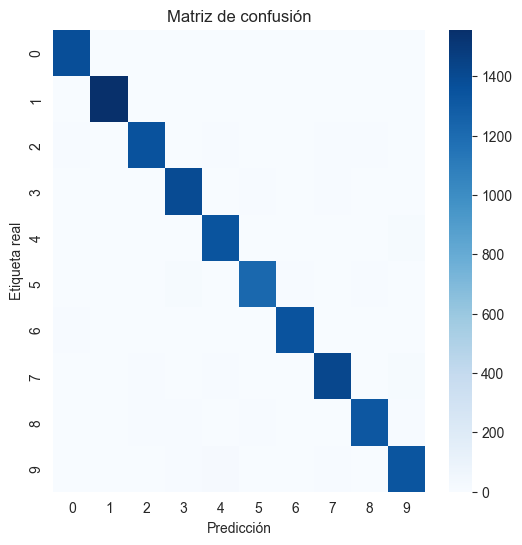

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = np.argmax(y_test_oh, axis=1)
y_pred = np.argmax(test_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Matriz de confusión")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.show()
